In [1]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime

In [2]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [3]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [4]:
def prep_aux_gad_jordan(k, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    H_accum = []
    for i in range(k):
        for j in range(i + 1, k):
            # Construct the pairwise interaction term for the ancillary space
            ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
            aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
            
            # Embed aux_H into the full space
            pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
            post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
            full_aux_H = tensor(pre_space + [aux_H] + post_space)
            
            H_accum.append(full_aux_H)
            
            ###### FOR PRINTING Aux #######
            to_p = (pre_space + ZZ + post_space)
            print_gadget(to_p)
            ###### FOR PRINTING Aux #######
    return H_accum


def prep_v_gad(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # aux = [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)]
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    ####### FOR PRINTING V #######
    to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return full_v
    

def prep_gadget(perturbation_factor, hs, total_logic_qbits):
    ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
    tot_space = total_logic_qbits + sum(ks)
    
    # Initialize the total Hamiltonian
    H_gad = []
    V = 0
 
    # Build auxiliary Hamiltonians and embed them
    current_position = total_logic_qbits  # Start after logical qubits

    for index, operator in enumerate(hs):        
        # print("Building gadget for operator", tensor_to_str(operator))
        k = ks[index]    
        
        H_gad_h = prep_aux_gad_jordan(k, current_position, tot_space)
        
        # Now adding the perturbative terms
        aux_count_v = 0
        for j, op in enumerate(operator):
            if op == I:
                continue     
            
            full_v = prep_v_gad(k, op, index, j, aux_count_v, current_position, ks)
            aux_count_v += 1
            
            H_gad_h.append(perturbation_factor*full_v)
            V += full_v
        
        current_position += k
        
        # fact = (math.factorial(k-1) /
        #         (-k*(-perturbation_factor)**k))

        fact = (math.factorial(k-1) /
                (-k*(-perturbation_factor)**k))
        # fact = 1
        H_gad.append([fact * i for i in H_gad_h])

    return H_gad, ks, V

In [5]:
X_L = [X, X, X]
Z_L = [Z, Z, Z]

hs = [X_L, Z_L]

# Parameters
total_logic_qbits = len(hs[0]) # Number of logical qubits
# print(H_gad)

tensor(I, I, I, Z, Z, I, I, I, I)
tensor(I, I, I, Z, I, Z, I, I, I)
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, X, I, I, I, I, I)
tensor(I, X, I, I, X, I, I, I, I)
tensor(I, I, X, I, I, X, I, I, I)
tensor(I, I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, I, Z, I, Z)
tensor(I, I, I, I, I, I, I, Z, Z)
tensor(Z, I, I, I, I, I, X, I, I)
tensor(I, Z, I, I, I, I, I, X, I)
tensor(I, I, Z, I, I, I, I, I, X)


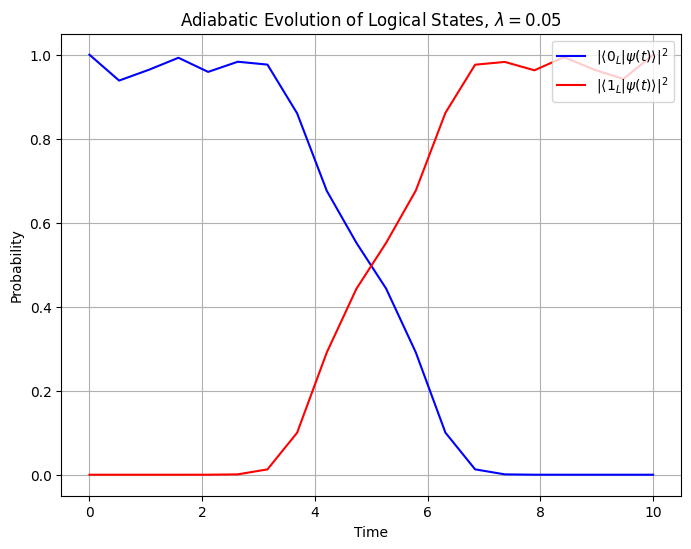

In [56]:
perturbation_factor = 0.05

H_gad, ks, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)

g1 = [I, Z, Z]
g2 = [Z, Z, I]
gs = [g1, g2]

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]

# Define the 4-qubit logical zero state |0_L>
logical_zero = tensor(basis_states[0], basis_states[0], basis_states[0])
logical_one = tensor(basis_states[1], basis_states[1], basis_states[1])

# RAP time-dependent terms
T = 10
t_list = np.linspace(0, T, 20)
sigma = 1
omega_max = 10

# Modified H_S_0 with gadgets
Ep = -100
H_p = 0
for g in gs:
    g_full = tensor(g + [I for _ in range(sum(ks))])
    H_p += Ep * g_full 

initial_state = logical_zero
for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()
    initial_state = tensor(initial_state, plus_state_anc)
    logical_one = tensor(logical_one, plus_state_anc)

X_L_gad = H_gad[0]
Z_L_gad = H_gad[1]

# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
    
    # check with Adi
    delta_factor = np.sign(delta_t) * np.abs(np.power(np.complex128(delta_t),1/3))
    
    return (sum(X_L_gad[:3]) + np.power(omega_t, 1/3) * sum(X_L_gad[3:]) + 
            sum(Z_L_gad[:3]) + delta_factor * sum(Z_L_gad[3:]) + 
            H_p)


args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}

    
P_init = initial_state * initial_state.dag()
P_one= logical_one * logical_one.dag()

# Solve the system with sesolve
H_td = QobjEvo(H_RAP, args=args)

options = Options(nsteps=1e6)
result = sesolve(H_td, initial_state, t_list, e_ops=[P_init, P_one], options=options)

# Extract probabilities
p_zero = result.expect[0]
p_one = result.expect[1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t_list, p_zero, label=r'$| \langle 0_{L} | \psi(t) \rangle |^2$', color='blue')
plt.plot(t_list, p_one, label=r'$| \langle 1_{L} | \psi(t) \rangle |^2$', color='red')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title(r'Adiabatic Evolution of Logical States, $\lambda = $' + str(perturbation_factor))
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [57]:
X_L = [X, X, X]
Z_L = [Z, Z, Z]

hs = [X_L, Z_L]

# Parameters
total_logic_qbits = len(hs[0]) # Number of logical qubits

g1 = [I, Z, Z]
g2 = [Z, Z, I]
gs = [g1, g2]

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]

# Define the 4-qubit logical zero state |0_L>
logical_zero = tensor(basis_states[0], basis_states[0], basis_states[0])

# RAP time-dependent terms
T = 10
t_list = np.linspace(0, T, 20)
sigma = 1
omega_max = 10

def H_eff(perturbation_factor):
    H_gad, ks, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)    

    # Modified H_S_0 with gadgets
    Ep = -100
    H_p = 0
    for g in gs:
        g_full = tensor(g + [I for _ in range(sum(ks))])
        H_p += Ep * g_full 
    
    initial_state = logical_zero
    for k in ks:
        plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                          tensor([basis(2, 1) for _ in range(k)])).unit()
        initial_state = tensor(initial_state, plus_state_anc)
    
    X_L_gad = H_gad[0]
    Z_L_gad = H_gad[1]
    
    # Define time-dependent Hamiltonian
    def H_RAP(t, args):
        omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
        delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
        
        # check with Adi
        delta_factor = np.sign(delta_t) * np.abs(np.power(np.complex128(delta_t),1/3))
        
        return (sum(X_L_gad[:3]) + np.power(omega_t, 1/3) * sum(X_L_gad[3:]) + 
                sum(Z_L_gad[:3]) + delta_factor * sum(Z_L_gad[3:]) + 
                H_p)
    
    
    args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
    
        
    P_init = initial_state * initial_state.dag()
    
    # Solve the system with sesolve
    H_td = QobjEvo(H_RAP, args=args)
    
    options = Options(nsteps=1e6)
    result = sesolve(H_td, initial_state, t_list, e_ops=[P_init], options=options)
    
    # Extract probabilities
    p_zero = result.expect[0]
    return p_zero

def H_id():
    # Modified H_S_0 with gadgets
    Ep = -100
    H_p = 0
    for g in gs:
        g_full = tensor(g)
        H_p += Ep * g_full 
    
    initial_state = logical_zero

    # Define time-dependent Hamiltonian
    def H_RAP(t, args):
        omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
        delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
        return omega_t * tensor(X_L) + delta_t * tensor(Z_L) + H_p
    
    args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
    
        
    P_init = initial_state * initial_state.dag()
    
    # Solve the system with sesolve
    H_td = QobjEvo(H_RAP, args=args)
    
    options = Options(nsteps=1e6)
    result = sesolve(H_td, initial_state, t_list, e_ops=[P_init], options=options)
    
    # Extract probabilities
    p_zero = result.expect[0]
    return p_zero

tensor(I, I, I, Z, Z, I, I, I, I)
tensor(I, I, I, Z, I, Z, I, I, I)
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, X, I, I, I, I, I)
tensor(I, X, I, I, X, I, I, I, I)
tensor(I, I, X, I, I, X, I, I, I)
tensor(I, I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, I, Z, I, Z)
tensor(I, I, I, I, I, I, I, Z, Z)
tensor(Z, I, I, I, I, I, X, I, I)
tensor(I, Z, I, I, I, I, I, X, I)
tensor(I, I, Z, I, I, I, I, I, X)
tensor(I, I, I, Z, Z, I, I, I, I)
tensor(I, I, I, Z, I, Z, I, I, I)
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, X, I, I, I, I, I)
tensor(I, X, I, I, X, I, I, I, I)
tensor(I, I, X, I, I, X, I, I, I)
tensor(I, I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, I, Z, I, Z)
tensor(I, I, I, I, I, I, I, Z, Z)
tensor(Z, I, I, I, I, I, X, I, I)
tensor(I, Z, I, I, I, I, I, X, I)
tensor(I, I, Z, I, I, I, I, I, X)
tensor(I, I, I, Z, Z, I, I, I, I)
tensor(I, I, I, Z, I, Z, I, I, I)
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, X, I, I, I, I, I)
tensor(I, X, I, I, X, I, I, I, I)
tensor(I, I, X

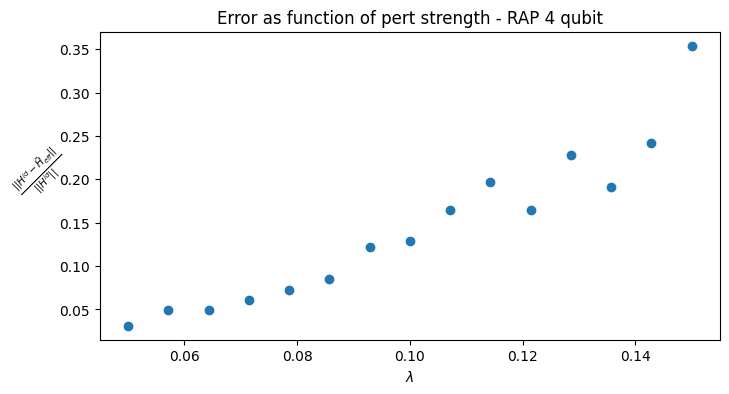

In [62]:
perts = np.linspace(0.05, 0.15, 15)
plt.figure(figsize=(8, 4))

dists = []
Hid = H_id()

for pert in perts:
    total_logic_qbits = len(hs[0])
    Heff = H_eff(pert)
    d = np.linalg.norm(Hid - Heff) / np.linalg.norm(Hid)
    dists.append(d)
plt.scatter(perts, dists)
        
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\frac{||H^{id} - \tilde{H}_{eff}||}{||H^{id}||}$", rotation=45)
plt.title(r"Error as function of pert strength - RAP 4 qubit")
plt.show()